In [1]:
import math
import datetime
import os
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2

import pyClientRLagentPytorch
import utils
from models import DifferentiablePhospheneSimulator,ThresholdedSobel, OrientedSobel, SurrogateCanny

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#replay memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
#model
class DQN(nn.Module):

    def __init__(self, h, w, input_channels, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [5]:
#utilities
#sound wave to be played when training is complete
wave= np.sin(2.6*np.pi*400*np.arange(10000)/10000)

def make_stack(frame, stack_size):
    stack_of_frames_initial = np.zeros((size, size, stack_size))
    for i in range(stack_size):
        stack_of_frames_initial[:,:,i] = frame
    return stack_of_frames_initial

def update_stack(stack, new_frame, stack_size):
    stack2 = stack.copy()
    for i in range(stack_size - 1):
        stack[:,:,i] = stack2[:,:,i+1].copy()
    stack[:,:,stack_size-1] = new_frame
    return stack 

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = max(EPS_END, (EPS_START-(EPS_DECAY*steps_done)))
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def state_to_blurred(raw_state, sigma):
    image_array = environment.state2usableArray(raw_state)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    ksize = 11 #np.round(4*sigma)+1
    blurred = cv2.GaussianBlur(image_array,(ksize,ksize),sigma)
    blurred = torch.tensor(blurred, device=device,dtype=torch.float).view(1,1,*blurred.shape)/255
    blurred = blurred.cpu().detach().numpy().squeeze()
    return blurred
    
def get_current_date():
    date = datetime.datetime.now()
    return date.strftime("%Y-%m-%d_%H-%M")

def get_model_name(v_b, v_w, v_l, v_t, i_e, t_e, t_r, t, impr):
    model_name_string = get_current_date()+"_Res"+str(phosphene_resolution[0])+"_Ep"+\
        str(i_e)+"_BoxBumps"+str(v_b)+"_WallBumps"+str(v_w)+"_Loops"+str(v_l)+"_Steps"+str(v_t)+"_TotalErrors"+\
        str(t_e)+"_TotalReward"+str(t_r)+"_Threshold"+str(t)+impr+".pth"
    return model_name_string

episode_rewards = []
loss_list = []
threshold_list = []
RUNNING_AVERAGE_NR = 20

def plot_rewards():
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())
    plt.figure(1, figsize=(16,4))
    plt.clf()
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy(), 'b', label = 'reward')
    # Take 20 episode averages and plot them too
    if len(rewards_t) >= RUNNING_AVERAGE_NR:
        means_r = rewards_t.unfold(0, RUNNING_AVERAGE_NR, 1).mean(1).view(-1)
        means_r = torch.cat((torch.zeros(RUNNING_AVERAGE_NR - 1), means_r))
        plt.plot(means_r.numpy(), 'c', label = str(RUNNING_AVERAGE_NR) +' episodes average reward')
    plt.legend()
    plt.pause(0.0001)  # pause a bit so that plots are updated

def plot_loss():
    plt.figure(2, figsize=(16,4))
    plt.clf()
    loss_t = torch.tensor(loss_list, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(loss_t.numpy(), 'g', label = 'loss')
    # Take 20 episode averages and plot them too
    if len(loss_t) >= RUNNING_AVERAGE_NR:
        loss_running_average = loss_t.unfold(0, RUNNING_AVERAGE_NR, 1).mean(1).view(-1)
        loss_running_average = torch.cat((torch.zeros(RUNNING_AVERAGE_NR - 1), loss_running_average))
        plt.plot(loss_running_average.numpy(), 'm', label = str(RUNNING_AVERAGE_NR) +' episodes average loss')
    plt.legend()
    plt.pause(0.0001)  # pause a bit so that plots are updated

def plot_threshold():
    plt.figure(3, figsize=(16,4))
    plt.clf()
    threshold_t = torch.tensor(threshold_list, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Threshold')
    plt.plot(threshold_t.numpy(), 'r', label = 'threshold')
    # Take 20 episode averages and plot them too
    if len(threshold_t) >= RUNNING_AVERAGE_NR:
        threshold_running_average = threshold_t.unfold(0, RUNNING_AVERAGE_NR, 1).mean(1).view(-1)
        threshold_running_average = torch.cat((torch.zeros(RUNNING_AVERAGE_NR - 1), threshold_running_average))
        plt.plot(threshold_running_average.numpy(), 'y', label = str(RUNNING_AVERAGE_NR) +' episodes average threshold')
    plt.legend()
    plt.pause(0.0001)  # pause a bit so that plots are updated


In [6]:
#single step for the optimization
def optimize_model(loss_list_nr_ep, simulator):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    state_batch = sobel_net(state_batch)
    state_batch = simulator(state_batch)
    
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    non_final_next_states = sobel_net_target(non_final_next_states)
    with torch.no_grad():
        non_final_next_states = simulator(non_final_next_states)
    
    
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    loss_list_nr_ep +=loss.item()
    # Optimize the model
    optimizer.zero_grad()
    optimizer_sobel.zero_grad()
    
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    nn.utils.clip_grad_norm_(sobel_net.parameters(), 1)

    optimizer.step()
    if sobel_optimization_start<memory_count:
        optimizer_sobel.step()
    
    return loss_list_nr_ep

In [7]:
def validation_loop(validation_episodes, i_episode, frame_size):
    environment.reset() #this ensures the validation seed will be set correctly with the next environment.reset_validation()
    numpy_training_seed = np.random.randint(0,9999999) #generate new seed for after validation
    np.random.seed(validation_np_random_seed) #set the random seed to the validation seed
    policy_net.eval()
    sobel_net.eval()
    box_bump_count = 0
    wall_bump_count_val = 0
    loop_count = 0
    total_steps_taken = 0
    reward_val = 0
    for ep in range(validation_episodes):
        simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
            jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device, channels = stack_size)
        
        print("Loop: "+str(ep + 1))
        wall_piece_hit = False
        steps_not_moved_forward = 0
        end, reward, state_raw = environment.reset_val()
        blurred = state_to_blurred(state_raw, SIGMA)    
    
        #create stack for current action
        stack_of_frames = make_stack(blurred, stack_size)
        state = stack_of_frames.transpose((2, 0, 1))
        state = torch.from_numpy(state).unsqueeze(0).to(device, dtype=torch.float)
        state = sobel_net(state)
        state = simulator(state)
        
        
        for t in count():
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            move = action.item()

            if move == 0:
                steps_not_moved_forward = 0
            else:
                steps_not_moved_forward += 1

            if steps_not_moved_forward >= 11:
                loop_count += 1
                move = 0
                steps_not_moved_forward = 0

            end, reward, next_state_raw = environment.step_val(move)            
            next_blurred = state_to_blurred(next_state_raw, SIGMA) 
            
            stack_of_frames = update_stack(stack_of_frames, next_blurred, stack_size)
            state = stack_of_frames.transpose((2, 0, 1))
            state = torch.from_numpy(state).unsqueeze(0).to(device, dtype=torch.float)
            state = sobel_net(state)
            state = simulator(state)
                        
            if reward == 120:
                box_bump_count +=1
            if reward == 110:
                if wall_piece_hit == False:
                    wall_bump_count_val += 1
                    wall_piece_hit = True
            else:
                wall_piece_hit = False
                
            if reward > 100:
                reward_val += -(reward -100)
            else:
                reward_val += reward
                
            if end == 2:
                total_steps_taken += t
                break
    
    total_errors = box_bump_count + wall_bump_count_val + loop_count      
    policy_net.train()
    sobel_net.train()
    np.random.seed(numpy_training_seed) #reset randomness with seed generated before the validation seed
    return box_bump_count/validation_episodes, wall_bump_count_val/validation_episodes, loop_count/validation_episodes, total_steps_taken/validation_episodes, total_errors/validation_episodes, reward_val/validation_episodes

In [8]:
#hyperparameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.001
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE = 1500 #steps taken
TARGET_UPDATE = 10 #episodes
SOBEL_TARGET_UPDATE = 1 #episodes

INITIAL_THRESHOLD = 0.3
sobel_optimization_start = 3500 #when to start optimizing threshold

validation_start = 800 #episodes
validation_interval = 10#episodes
validation_loops = 5

stack_size = 4

size       = 128
# screenshot size
screen_height = screen_width = size

input_channels = stack_size
n_actions = 3

sobel_net = ThresholdedSobel(initial_threshold = INITIAL_THRESHOLD, k_size =5, device = device, channels = stack_size).to(device)
sobel_net_target = ThresholdedSobel(initial_threshold = INITIAL_THRESHOLD, k_size =5, device = device, channels = stack_size).to(device)
sobel_net_target.load_state_dict(sobel_net.state_dict())
sobel_net_target.eval()

policy_net = DQN(screen_height, screen_width, input_channels, n_actions).to(device)
target_net = DQN(screen_height, screen_width, input_channels, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
summary(policy_net, (input_channels, size, size))

lr_start_sobel = 0.005
lr_end_sobel = 0.0004
episodes_to_decay_sobel = 600

lr_dqn = 0.001


optimizer = optim.Adam(policy_net.parameters(), lr = lr_dqn)
optimizer_sobel = optim.Adam(sobel_net.parameters(), lr = lr_start_sobel)


memory = ReplayMemory(12000) 
#working combos rtx 2080, 8GB vram:
# size / memory / batch / phosphenes/ stack_size / neural_network
# 128  / 12000  / 128   / yes       / 4          / original DQN (can go a bit higher)
steps_done = 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]           1,616
       BatchNorm2d-2           [-1, 16, 62, 62]              32
            Conv2d-3           [-1, 32, 29, 29]          12,832
       BatchNorm2d-4           [-1, 32, 29, 29]              64
            Conv2d-5           [-1, 32, 13, 13]          25,632
       BatchNorm2d-6           [-1, 32, 13, 13]              64
            Linear-7                    [-1, 3]          16,227
Total params: 56,467
Trainable params: 56,467
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 1.43
Params size (MB): 0.22
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


In [9]:
# Unity environment
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
timescale  = 1           # update step scale for unity

environment = pyClientRLagentPytorch.Environment(ip = ip, port = port, size = size, timescale = timescale) 

In [10]:
#change here and in unity
COMPLEX = 0
light_in_low = 0.4
light_in_up = 0.6


SIGMA = 0.4

phosphene_resolution= (42,42)

num_episodes = 1001

PATH = "./Models/"+get_current_date()+"_Res"+str(phosphene_resolution[0]) + "_Complex" + str(COMPLEX)+ "_lightInLow"+str(light_in_low) + "_lightInUp"+ str(light_in_up)
os.mkdir(PATH)

frame_width = 1024
frame_height = 1024
frame_size = (frame_width, frame_height)

validation_np_random_seed = 796580
memory_count = 0
val_least_bumps = 10000
val_least_steps = 10000
val_least_wall_bumps = 10000
val_least_loops = 10000
val_least_errors = 40000
val_best_reward = 0
val_best_episode = 0
val_best_threshold = INITIAL_THRESHOLD

for i_episode in range(num_episodes):
    
    #change learning rate sobel
    optimizer_sobel.param_groups[0]['lr'] = max(lr_start_sobel-(((lr_start_sobel-lr_end_sobel)/episodes_to_decay_sobel)*i_episode),lr_end_sobel)
    print(optimizer_sobel.param_groups[0]['lr'])
    
    # Initialize the environment and state
    #phosphene simulator aanroepen zonder numpy seed
    simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device, channels = stack_size) 
    reward_count = 0
    loss_list_nr = 0
    threshold_nr = 0
    threshold_average = 0
    end, reward, state_raw = environment.reset()
    blurred = state_to_blurred(state_raw, SIGMA)
    
    
    #create stack for memory and current action
    stack_of_frames = make_stack(blurred, stack_size)
    state_mem = stack_of_frames.transpose((2, 0, 1))
    state_mem = torch.from_numpy(state_mem).unsqueeze(0).to(device, dtype=torch.float)
    state = sobel_net(state_mem)
    state = simulator(state)
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        
        end, reward, next_state_raw = environment.step(action.item())
   
        if reward > 100:
            reward = -(reward -100)

        #reward = reward/10
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if end == 0 or end == 2:
            next_blurred = state_to_blurred(next_state_raw, SIGMA)            
            stack_of_frames = update_stack(stack_of_frames, next_blurred, stack_size)
            next_state_mem = stack_of_frames.transpose((2, 0, 1))
            next_state_mem = torch.from_numpy(next_state_mem).unsqueeze(0).to(device, dtype=torch.float)
            next_state = sobel_net(next_state_mem)
            next_state = simulator(next_state)
            
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state_mem, action, next_state_mem, reward)

        # Move to the next state
        state = next_state
        state_mem = next_state_mem

        # Perform one step of the optimization (on the target network) when memory is filled enough
        if (memory_count+t) > REPLAY_START_SIZE:
            loss_list_nr = optimize_model(loss_list_nr, simulator)
        else:
            steps_done = 0
        
        threshold_nr += sobel_net.threshold.item()
        reward_count += int(reward)
            
        if end != 0:
            memory_count += (t + 1)
            loss_list.append(loss_list_nr/(t+1))
            threshold_average = threshold_nr/(t+1)
            threshold_list.append(threshold_average)
            episode_rewards.append(reward_count)
            plot_rewards()
            plot_loss()
            plot_threshold()
            #plt.imshow(next_frame, cmap='gray')
            #plt.show()
            print(memory_count)
            print(sobel_net.threshold.item())
            break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0 and memory_count >= REPLAY_START_SIZE:
        print(i_episode)
        target_net.load_state_dict(policy_net.state_dict())
        
    # Update the sobel target network, copying all weights and biases in DQN
    if i_episode % SOBEL_TARGET_UPDATE == 0 and memory_count >= REPLAY_START_SIZE:
        print(i_episode)
        sobel_net_target.load_state_dict(sobel_net.state_dict())
    
    if i_episode % validation_interval == 0 and i_episode >= validation_start:
        if is_ipython:
            display.clear_output(wait=True)
        improved = ""
        print("Validating episode " +str(i_episode)+".." + '\n')
        print(max(EPS_END, (EPS_START-(EPS_DECAY*steps_done))))
        #start the validation session
        val_box, val_wall, val_loop, val_time, val_total_errors, val_total_reward = validation_loop(validation_loops, i_episode, frame_size)
        val_threshold = sobel_net.threshold.item()
        print("")
        print("Previous best episode: " + str(val_best_episode))
        print("Previous least box bumps val: " + str(val_least_bumps))
        print("Previous least wall bumps val: " + str(val_least_wall_bumps))
        print("Previous least loops val: " + str(val_least_loops))
        print("Previous least steps val: " + str(val_least_steps))
        print("Previous least total errors val: " + str(val_least_errors))
        print("Previous best reward val: " + str(val_best_reward))
        print("Previous best threshold val: " + str(val_best_threshold) + '\n')
        
        print("Current episode: " + str(i_episode))
        print("Current box bumps val: " + str(val_box))
        print("Current wall bumps vall: " + str(val_wall))
        print("Current loops val: " + str(val_loop))
        print("Current steps val: " + str(val_time))
        print("Current total errors val: " + str(val_total_errors))
        print("Current total reward val: " + str(val_total_reward))
        print("Current threshold val: " + str(val_threshold) + '\n')
        if val_total_reward > val_best_reward:
            print("Agent improved because the reward increased!")
            val_least_bumps = val_box
            val_least_wall_bumps = val_wall
            val_least_loops = val_loop
            val_least_steps = val_time
            val_best_episode = i_episode
            val_least_errors = val_total_errors
            val_best_reward = val_total_reward
            val_best_threshold = val_threshold
            improved = "_Improved"
        elif val_total_reward == val_best_reward:
            if val_total_errors < val_least_errors:
                print("Agent improved because it made less errors with equal reward!")
                val_least_bumps = val_box
                val_least_wall_bumps = val_wall
                val_least_loops = val_loop
                val_least_steps = val_time
                val_best_episode = i_episode
                val_least_errors = val_total_errors
                val_best_reward = val_total_reward
                val_best_threshold = val_threshold
                improved = "_Improved"
            elif val_total_errors == val_least_errors:
                if val_time < val_least_steps:
                    print("Agent improved because it took less steps with equal reward and errors!")
                    val_least_bumps = val_box
                    val_least_wall_bumps = val_wall
                    val_least_loops = val_loop
                    val_least_steps = val_time
                    val_best_episode = i_episode
                    val_least_errors = val_total_errors
                    val_best_reward = val_total_reward
                    val_best_threshold = val_threshold
                    improved = "_Improved"

        model_name = get_model_name(val_box, val_wall, val_loop, val_time, i_episode, val_total_errors, val_total_reward, val_threshold, improved)
        torch.save(policy_net.state_dict(), PATH + "/" + model_name)


print('Complete')

plt.ioff()
plt.show()

Validating episode 1000..

0.001
Loop: 1
Loop: 2
Loop: 3
Loop: 4
Loop: 5

Previous best episode: 800
Previous least box bumps val: 1.8
Previous least wall bumps val: 0.2
Previous least loops val: 0.0
Previous least steps val: 330.2
Previous least total errors val: 2.0
Previous best reward val: 2902.4
Previous best threshold val: 0.31071555614471436

Current episode: 1000
Current box bumps val: 2.8
Current wall bumps vall: 0.0
Current loops val: 0.2
Current steps val: 331.0
Current total errors val: 3.0
Current total reward val: 2873.0
Current threshold val: 0.3400861322879791

Complete


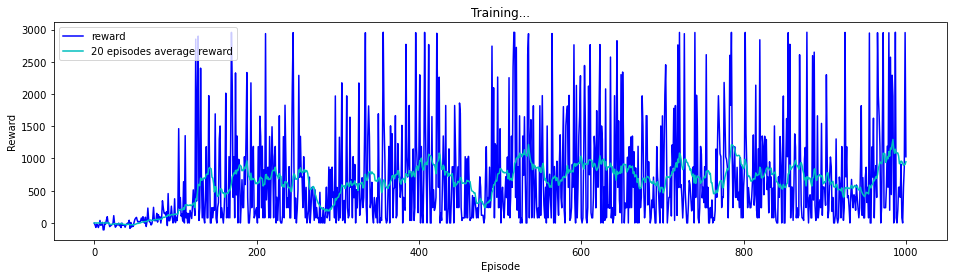

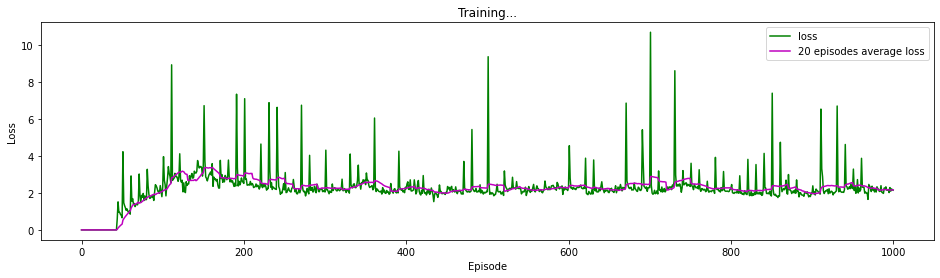

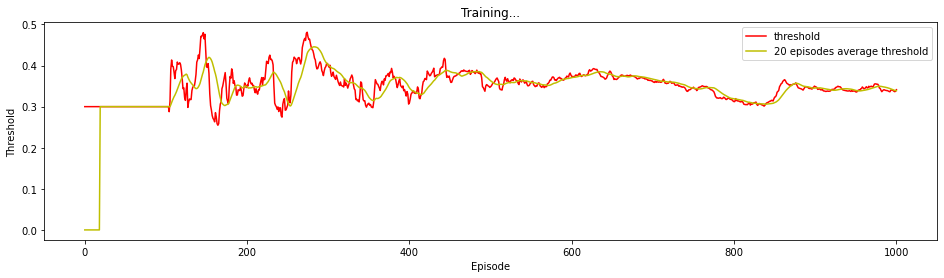

In [11]:
plot_rewards()
plot_loss()
plot_threshold()
#play sound when done
Audio(wave, rate=10000, autoplay=True)


In [12]:
print(optimizer_sobel.param_groups[0]['lr'])
print(sobel_net.threshold.item())

0.0004
0.3400861322879791
